# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import estimate_market_factors as emf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-07-24"
stock_index_name = "gdaxi"

time_delta = 240
time_step = 20

## Load data and filter duplicates by symbol and date

In [3]:
# Load data and filter duplicates by symbol and date
df_stock_index = pd.read_csv(
    "{}/df_stock_index_{}_{}.csv".format(
        input_path_processed,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    low_memory = False
)

df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)
df_stock_index["date"] = pd.to_datetime(df_stock_index["date"], errors = "coerce")

## Rolling window analysis

In [4]:
market_args_list = df_stock_index[["date"]].sort_values(by = ["date"]).value_counts(sort = False).reset_index()
market_args_list["final_date"] = market_args_list["date"] + pd.DateOffset(days = time_delta)
market_args_list = (
    market_args_list
        .rename(columns = {"date" : "initial_date"})
        .iloc[::time_step]
        .reset_index()
        .drop(columns = ["count", "index"])
)
market_args_list["initial_date"] = market_args_list["initial_date"].astype(str)
market_args_list["final_date"] = market_args_list["final_date"].astype(str)
market_args_list#.values.tolist()

,initial_date,final_date
0,2000-01-04,2000-08-31
1,2000-02-01,2000-09-28
2,2000-02-29,2000-10-26
3,2000-03-28,2000-11-23
4,2000-04-27,2000-12-23
...,...,...
307,2024-03-06,2024-11-01
308,2024-04-05,2024-12-01
309,2024-05-06,2025-01-01
310,2024-06-03,2025-01-29


In [5]:
%%time
# Normalized Returns
df_final_3 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_log_return",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_rolling_window_{}".format(stock_index_name),
            log_filename_entropy = "log_entropy_rolling_{}".format(stock_index_name),
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_3.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_3 = pd.concat(df_final_3)

100%|████████████████████| 378/378 [00:00<00:00, 603.71it/s]


Finished: 2000-01-04 - 2000-08-31


100%|████████████████████| 378/378 [00:00<00:00, 553.84it/s]


Finished: 2000-02-01 - 2000-09-28


100%|████████████████████| 378/378 [00:00<00:00, 538.22it/s]


Finished: 2000-02-29 - 2000-10-26


100%|████████████████████| 378/378 [00:00<00:00, 634.25it/s]


Finished: 2000-03-28 - 2000-11-23


100%|████████████████████| 406/406 [00:00<00:00, 627.79it/s]


Finished: 2000-04-27 - 2000-12-23


100%|████████████████████| 406/406 [00:00<00:00, 616.56it/s]


Finished: 2000-05-26 - 2001-01-21


100%|████████████████████| 406/406 [00:00<00:00, 635.74it/s]


Finished: 2000-06-23 - 2001-02-18


100%|████████████████████| 406/406 [00:00<00:00, 623.33it/s]


Finished: 2000-07-21 - 2001-03-18


100%|████████████████████| 435/435 [00:00<00:00, 629.36it/s]


Finished: 2000-08-18 - 2001-04-15


100%|████████████████████| 465/465 [00:00<00:00, 579.05it/s]


Finished: 2000-09-15 - 2001-05-13


100%|████████████████████| 465/465 [00:00<00:00, 640.21it/s]


Finished: 2000-10-16 - 2001-06-13


100%|████████████████████| 496/496 [00:00<00:00, 614.30it/s]


Finished: 2000-11-13 - 2001-07-11


100%|████████████████████| 496/496 [00:00<00:00, 541.62it/s]


Finished: 2000-12-11 - 2001-08-08


100%|████████████████████| 496/496 [00:00<00:00, 605.47it/s]


Finished: 2001-01-11 - 2001-09-08


100%|████████████████████| 496/496 [00:00<00:00, 570.36it/s]


Finished: 2001-02-08 - 2001-10-06


100%|████████████████████| 496/496 [00:00<00:00, 614.62it/s]


Finished: 2001-03-08 - 2001-11-03


100%|████████████████████| 496/496 [00:00<00:00, 616.73it/s]


Finished: 2001-04-05 - 2001-12-01


100%|████████████████████| 496/496 [00:00<00:00, 572.39it/s]


Finished: 2001-05-08 - 2002-01-03


100%|████████████████████| 496/496 [00:00<00:00, 564.69it/s]


Finished: 2001-06-05 - 2002-01-31


100%|████████████████████| 496/496 [00:00<00:00, 592.71it/s]


Finished: 2001-07-03 - 2002-02-28


100%|████████████████████| 496/496 [00:00<00:00, 530.50it/s]


Finished: 2001-07-31 - 2002-03-28


100%|████████████████████| 496/496 [00:00<00:00, 609.22it/s]


Finished: 2001-08-28 - 2002-04-25


100%|████████████████████| 496/496 [00:00<00:00, 615.71it/s]


Finished: 2001-09-25 - 2002-05-23


100%|████████████████████| 496/496 [00:00<00:00, 550.86it/s]


Finished: 2001-10-23 - 2002-06-20


100%|████████████████████| 496/496 [00:00<00:00, 564.09it/s]


Finished: 2001-11-20 - 2002-07-18


100%|████████████████████| 496/496 [00:00<00:00, 589.30it/s]


Finished: 2001-12-18 - 2002-08-15


100%|████████████████████| 496/496 [00:00<00:00, 504.18it/s]


Finished: 2002-01-22 - 2002-09-19


100%|████████████████████| 496/496 [00:00<00:00, 557.56it/s]


Finished: 2002-02-19 - 2002-10-17


100%|████████████████████| 496/496 [00:00<00:00, 536.70it/s]


Finished: 2002-03-19 - 2002-11-14


100%|████████████████████| 496/496 [00:00<00:00, 504.14it/s]


Finished: 2002-04-18 - 2002-12-14


100%|████████████████████| 496/496 [00:00<00:00, 571.82it/s]


Finished: 2002-05-17 - 2003-01-12


100%|████████████████████| 496/496 [00:00<00:00, 550.88it/s]


Finished: 2002-06-14 - 2003-02-09


100%|████████████████████| 496/496 [00:00<00:00, 532.99it/s]


Finished: 2002-07-12 - 2003-03-09


100%|████████████████████| 496/496 [00:00<00:00, 599.07it/s]


Finished: 2002-08-09 - 2003-04-06


100%|████████████████████| 465/465 [00:00<00:00, 598.80it/s]


Finished: 2002-09-06 - 2003-05-04


100%|████████████████████| 465/465 [00:00<00:00, 599.78it/s]


Finished: 2002-10-04 - 2003-06-01


100%|████████████████████| 465/465 [00:00<00:00, 554.02it/s]


Finished: 2002-11-01 - 2003-06-29


100%|████████████████████| 465/465 [00:00<00:00, 560.39it/s]


Finished: 2002-11-29 - 2003-07-27


100%|████████████████████| 465/465 [00:00<00:00, 559.74it/s]


Finished: 2003-01-02 - 2003-08-30


100%|████████████████████| 465/465 [00:00<00:00, 555.04it/s]


Finished: 2003-01-30 - 2003-09-27


100%|████████████████████| 465/465 [00:00<00:00, 606.55it/s]


Finished: 2003-02-27 - 2003-10-25


100%|████████████████████| 465/465 [00:00<00:00, 618.15it/s]


Finished: 2003-03-27 - 2003-11-22


100%|████████████████████| 465/465 [00:00<00:00, 621.28it/s]


Finished: 2003-04-28 - 2003-12-24


100%|████████████████████| 496/496 [00:00<00:00, 579.03it/s]


Finished: 2003-05-27 - 2004-01-22


100%|████████████████████| 496/496 [00:00<00:00, 612.45it/s]


Finished: 2003-06-24 - 2004-02-19


100%|████████████████████| 496/496 [00:00<00:00, 596.23it/s]


Finished: 2003-07-22 - 2004-03-18


100%|████████████████████| 496/496 [00:01<00:00, 493.07it/s]


Finished: 2003-08-19 - 2004-04-15


100%|████████████████████| 496/496 [00:00<00:00, 549.20it/s]


Finished: 2003-09-16 - 2004-05-13


100%|████████████████████| 496/496 [00:00<00:00, 549.26it/s]


Finished: 2003-10-14 - 2004-06-10


100%|████████████████████| 496/496 [00:01<00:00, 494.88it/s]


Finished: 2003-11-11 - 2004-07-08


100%|████████████████████| 496/496 [00:00<00:00, 574.60it/s]


Finished: 2003-12-09 - 2004-08-05


100%|████████████████████| 496/496 [00:00<00:00, 558.78it/s]


Finished: 2004-01-13 - 2004-09-09


100%|████████████████████| 496/496 [00:00<00:00, 530.61it/s]


Finished: 2004-02-10 - 2004-10-07


100%|████████████████████| 496/496 [00:00<00:00, 574.95it/s]


Finished: 2004-03-09 - 2004-11-04


100%|████████████████████| 496/496 [00:00<00:00, 563.14it/s]


Finished: 2004-04-06 - 2004-12-02


100%|████████████████████| 496/496 [00:00<00:00, 513.22it/s]


Finished: 2004-05-06 - 2005-01-01


100%|████████████████████| 496/496 [00:00<00:00, 576.92it/s]


Finished: 2004-06-03 - 2005-01-29


100%|████████████████████| 496/496 [00:00<00:00, 596.65it/s]


Finished: 2004-07-01 - 2005-02-26


100%|████████████████████| 496/496 [00:00<00:00, 538.19it/s]


Finished: 2004-07-29 - 2005-03-26


100%|████████████████████| 496/496 [00:00<00:00, 576.88it/s]


Finished: 2004-08-26 - 2005-04-23


100%|████████████████████| 496/496 [00:00<00:00, 568.51it/s]


Finished: 2004-09-23 - 2005-05-21


100%|████████████████████| 496/496 [00:00<00:00, 561.67it/s]


Finished: 2004-10-21 - 2005-06-18


100%|████████████████████| 496/496 [00:00<00:00, 572.73it/s]


Finished: 2004-11-18 - 2005-07-16


100%|████████████████████| 496/496 [00:00<00:00, 506.64it/s]


Finished: 2004-12-16 - 2005-08-13


100%|████████████████████| 496/496 [00:00<00:00, 567.70it/s]


Finished: 2005-01-17 - 2005-09-14


100%|████████████████████| 496/496 [00:00<00:00, 503.54it/s]


Finished: 2005-02-14 - 2005-10-12


100%|████████████████████| 528/528 [00:01<00:00, 527.94it/s]


Finished: 2005-03-14 - 2005-11-09


100%|████████████████████| 528/528 [00:00<00:00, 594.35it/s]


Finished: 2005-04-13 - 2005-12-09


100%|████████████████████| 528/528 [00:00<00:00, 598.18it/s]


Finished: 2005-05-11 - 2006-01-06


100%|████████████████████| 528/528 [00:00<00:00, 537.57it/s]


Finished: 2005-06-08 - 2006-02-03


100%|████████████████████| 528/528 [00:00<00:00, 542.87it/s]


Finished: 2005-07-06 - 2006-03-03


100%|████████████████████| 528/528 [00:00<00:00, 567.55it/s]


Finished: 2005-08-03 - 2006-03-31


100%|████████████████████| 528/528 [00:00<00:00, 586.89it/s]


Finished: 2005-08-31 - 2006-04-28


100%|████████████████████| 528/528 [00:00<00:00, 566.14it/s]


Finished: 2005-09-28 - 2006-05-26


100%|████████████████████| 528/528 [00:01<00:00, 525.40it/s]


Finished: 2005-10-26 - 2006-06-23


100%|████████████████████| 528/528 [00:00<00:00, 609.32it/s]


Finished: 2005-11-23 - 2006-07-21


100%|████████████████████| 528/528 [00:00<00:00, 547.31it/s]


Finished: 2005-12-21 - 2006-08-18


100%|████████████████████| 528/528 [00:01<00:00, 498.09it/s]


Finished: 2006-01-19 - 2006-09-16


100%|████████████████████| 528/528 [00:00<00:00, 566.63it/s]


Finished: 2006-02-16 - 2006-10-14


100%|████████████████████| 528/528 [00:00<00:00, 569.88it/s]


Finished: 2006-03-16 - 2006-11-11


100%|████████████████████| 528/528 [00:00<00:00, 577.63it/s]


Finished: 2006-04-13 - 2006-12-09


100%|████████████████████| 528/528 [00:00<00:00, 559.82it/s]


Finished: 2006-05-16 - 2007-01-11


100%|████████████████████| 528/528 [00:01<00:00, 505.68it/s]


Finished: 2006-06-13 - 2007-02-08


100%|████████████████████| 528/528 [00:00<00:00, 582.66it/s]


Finished: 2006-07-11 - 2007-03-08


100%|████████████████████| 528/528 [00:00<00:00, 547.95it/s]


Finished: 2006-08-08 - 2007-04-05


100%|████████████████████| 528/528 [00:00<00:00, 532.41it/s]


Finished: 2006-09-05 - 2007-05-03


100%|████████████████████| 561/561 [00:00<00:00, 582.05it/s]


Finished: 2006-10-03 - 2007-05-31


100%|████████████████████| 595/595 [00:01<00:00, 576.14it/s]


Finished: 2006-10-31 - 2007-06-28


100%|████████████████████| 595/595 [00:01<00:00, 566.38it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:01<00:00, 555.60it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:01<00:00, 515.31it/s]


Finished: 2007-01-26 - 2007-09-23


100%|████████████████████| 595/595 [00:00<00:00, 605.35it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:01<00:00, 536.10it/s]


Finished: 2007-03-23 - 2007-11-18


100%|████████████████████| 595/595 [00:01<00:00, 556.72it/s]


Finished: 2007-04-24 - 2007-12-20


100%|████████████████████| 595/595 [00:01<00:00, 555.36it/s]


Finished: 2007-05-23 - 2008-01-18


100%|████████████████████| 595/595 [00:01<00:00, 568.40it/s]


Finished: 2007-06-21 - 2008-02-16


100%|████████████████████| 595/595 [00:01<00:00, 577.04it/s]


Finished: 2007-07-19 - 2008-03-15


100%|████████████████████| 595/595 [00:01<00:00, 538.14it/s]


Finished: 2007-08-16 - 2008-04-12


100%|████████████████████| 595/595 [00:01<00:00, 592.54it/s]


Finished: 2007-09-13 - 2008-05-10


100%|████████████████████| 595/595 [00:01<00:00, 519.89it/s]


Finished: 2007-10-11 - 2008-06-07


100%|████████████████████| 595/595 [00:01<00:00, 571.39it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:01<00:00, 518.56it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:01<00:00, 476.38it/s]


Finished: 2008-01-10 - 2008-09-06


100%|████████████████████| 595/595 [00:01<00:00, 560.35it/s]


Finished: 2008-02-07 - 2008-10-04


100%|████████████████████| 561/561 [00:01<00:00, 489.32it/s]


Finished: 2008-03-06 - 2008-11-01


100%|████████████████████| 561/561 [00:01<00:00, 558.06it/s]


Finished: 2008-04-07 - 2008-12-03


100%|████████████████████| 561/561 [00:01<00:00, 557.66it/s]


Finished: 2008-05-06 - 2009-01-01


100%|████████████████████| 561/561 [00:00<00:00, 561.73it/s]


Finished: 2008-06-03 - 2009-01-29


100%|████████████████████| 561/561 [00:00<00:00, 578.55it/s]


Finished: 2008-07-01 - 2009-02-26


100%|████████████████████| 561/561 [00:01<00:00, 495.18it/s]


Finished: 2008-07-29 - 2009-03-26


100%|████████████████████| 561/561 [00:00<00:00, 575.12it/s]


Finished: 2008-08-26 - 2009-04-23


100%|████████████████████| 561/561 [00:01<00:00, 550.77it/s]


Finished: 2008-09-23 - 2009-05-21


100%|████████████████████| 561/561 [00:01<00:00, 451.35it/s]


Finished: 2008-10-21 - 2009-06-18


100%|████████████████████| 595/595 [00:01<00:00, 556.25it/s]


Finished: 2008-11-18 - 2009-07-16


100%|████████████████████| 595/595 [00:01<00:00, 500.92it/s]


Finished: 2008-12-16 - 2009-08-13


100%|████████████████████| 595/595 [00:01<00:00, 568.50it/s]


Finished: 2009-01-20 - 2009-09-17


100%|████████████████████| 595/595 [00:01<00:00, 503.47it/s]


Finished: 2009-02-17 - 2009-10-15


100%|████████████████████| 595/595 [00:01<00:00, 525.64it/s]


Finished: 2009-03-17 - 2009-11-12


100%|████████████████████| 595/595 [00:01<00:00, 536.26it/s]


Finished: 2009-04-16 - 2009-12-12


100%|████████████████████| 595/595 [00:01<00:00, 534.77it/s]


Finished: 2009-05-15 - 2010-01-10


100%|████████████████████| 595/595 [00:01<00:00, 575.14it/s]


Finished: 2009-06-12 - 2010-02-07


100%|████████████████████| 595/595 [00:01<00:00, 508.90it/s]


Finished: 2009-07-10 - 2010-03-07


100%|████████████████████| 595/595 [00:01<00:00, 548.52it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:01<00:00, 515.70it/s]


Finished: 2009-09-04 - 2010-05-02


100%|████████████████████| 595/595 [00:01<00:00, 517.14it/s]


Finished: 2009-10-02 - 2010-05-30


100%|████████████████████| 595/595 [00:01<00:00, 540.94it/s]


Finished: 2009-10-30 - 2010-06-27


100%|████████████████████| 595/595 [00:01<00:00, 501.74it/s]


Finished: 2009-11-27 - 2010-07-25


100%|████████████████████| 595/595 [00:01<00:00, 554.41it/s]


Finished: 2009-12-29 - 2010-08-26


100%|████████████████████| 630/630 [00:01<00:00, 503.67it/s]


Finished: 2010-01-28 - 2010-09-25


100%|████████████████████| 630/630 [00:01<00:00, 520.76it/s]


Finished: 2010-02-25 - 2010-10-23


100%|████████████████████| 630/630 [00:01<00:00, 544.80it/s]


Finished: 2010-03-25 - 2010-11-20


100%|████████████████████| 630/630 [00:01<00:00, 573.75it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:01<00:00, 570.40it/s]


Finished: 2010-05-24 - 2011-01-19


100%|████████████████████| 630/630 [00:01<00:00, 517.41it/s]


Finished: 2010-06-21 - 2011-02-16


100%|████████████████████| 630/630 [00:01<00:00, 565.37it/s]


Finished: 2010-07-19 - 2011-03-16


100%|████████████████████| 630/630 [00:01<00:00, 520.41it/s]


Finished: 2010-08-16 - 2011-04-13


100%|████████████████████| 630/630 [00:01<00:00, 557.48it/s]


Finished: 2010-09-13 - 2011-05-11


100%|████████████████████| 630/630 [00:01<00:00, 535.67it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:01<00:00, 558.45it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:01<00:00, 576.03it/s]


Finished: 2010-12-06 - 2011-08-03


100%|████████████████████| 630/630 [00:01<00:00, 558.99it/s]


Finished: 2011-01-05 - 2011-09-02


100%|████████████████████| 630/630 [00:01<00:00, 569.10it/s]


Finished: 2011-02-02 - 2011-09-30


100%|████████████████████| 630/630 [00:01<00:00, 527.74it/s]


Finished: 2011-03-02 - 2011-10-28


100%|████████████████████| 630/630 [00:01<00:00, 535.36it/s]


Finished: 2011-03-30 - 2011-11-25


100%|████████████████████| 630/630 [00:01<00:00, 504.17it/s]


Finished: 2011-04-29 - 2011-12-25


100%|████████████████████| 630/630 [00:01<00:00, 583.95it/s]


Finished: 2011-05-27 - 2012-01-22


100%|████████████████████| 630/630 [00:01<00:00, 545.06it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:01<00:00, 579.32it/s]


Finished: 2011-07-22 - 2012-03-18


100%|████████████████████| 630/630 [00:01<00:00, 563.93it/s]


Finished: 2011-08-19 - 2012-04-15


100%|████████████████████| 630/630 [00:01<00:00, 569.80it/s]


Finished: 2011-09-16 - 2012-05-13


100%|████████████████████| 630/630 [00:01<00:00, 574.89it/s]


Finished: 2011-10-17 - 2012-06-13


100%|████████████████████| 630/630 [00:01<00:00, 546.45it/s]


Finished: 2011-11-14 - 2012-07-11


100%|████████████████████| 630/630 [00:01<00:00, 577.99it/s]


Finished: 2011-12-12 - 2012-08-08


100%|████████████████████| 630/630 [00:01<00:00, 546.80it/s]


Finished: 2012-01-10 - 2012-09-06


100%|████████████████████| 630/630 [00:01<00:00, 552.22it/s]


Finished: 2012-02-07 - 2012-10-04


100%|████████████████████| 630/630 [00:01<00:00, 546.60it/s]


Finished: 2012-03-06 - 2012-11-01


100%|████████████████████| 630/630 [00:01<00:00, 571.24it/s]


Finished: 2012-04-03 - 2012-11-29


100%|████████████████████| 630/630 [00:01<00:00, 556.41it/s]


Finished: 2012-05-04 - 2012-12-30


100%|████████████████████| 630/630 [00:01<00:00, 460.19it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:01<00:00, 572.18it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:01<00:00, 549.62it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:01<00:00, 571.55it/s]


Finished: 2012-08-24 - 2013-04-21


100%|████████████████████| 630/630 [00:01<00:00, 502.14it/s]


Finished: 2012-09-21 - 2013-05-19


100%|████████████████████| 630/630 [00:01<00:00, 548.86it/s]


Finished: 2012-10-22 - 2013-06-19


100%|████████████████████| 630/630 [00:01<00:00, 574.08it/s]


Finished: 2012-11-19 - 2013-07-17


100%|████████████████████| 630/630 [00:01<00:00, 555.50it/s]


Finished: 2012-12-17 - 2013-08-14


100%|████████████████████| 630/630 [00:01<00:00, 519.66it/s]


Finished: 2013-01-21 - 2013-09-18


100%|████████████████████| 630/630 [00:01<00:00, 534.29it/s]


Finished: 2013-02-18 - 2013-10-16


100%|████████████████████| 630/630 [00:01<00:00, 547.29it/s]


Finished: 2013-03-18 - 2013-11-13


100%|████████████████████| 666/666 [00:01<00:00, 563.05it/s]


Finished: 2013-04-17 - 2013-12-13


100%|████████████████████| 666/666 [00:01<00:00, 594.70it/s]


Finished: 2013-05-16 - 2014-01-11


100%|████████████████████| 666/666 [00:01<00:00, 563.89it/s]


Finished: 2013-06-13 - 2014-02-08


100%|████████████████████| 666/666 [00:01<00:00, 553.12it/s]


Finished: 2013-07-11 - 2014-03-08


100%|████████████████████| 666/666 [00:01<00:00, 500.57it/s]


Finished: 2013-08-08 - 2014-04-05


100%|████████████████████| 666/666 [00:01<00:00, 584.65it/s]


Finished: 2013-09-05 - 2014-05-03


100%|████████████████████| 666/666 [00:01<00:00, 502.19it/s]


Finished: 2013-10-04 - 2014-06-01


100%|████████████████████| 666/666 [00:01<00:00, 592.36it/s]


Finished: 2013-11-01 - 2014-06-29


100%|████████████████████| 666/666 [00:01<00:00, 576.60it/s]


Finished: 2013-11-29 - 2014-07-27


100%|████████████████████| 666/666 [00:01<00:00, 572.66it/s]


Finished: 2014-01-03 - 2014-08-31


100%|████████████████████| 666/666 [00:01<00:00, 570.53it/s]


Finished: 2014-01-31 - 2014-09-28


100%|████████████████████| 666/666 [00:01<00:00, 560.05it/s]


Finished: 2014-02-28 - 2014-10-26


100%|████████████████████| 666/666 [00:01<00:00, 512.93it/s]


Finished: 2014-03-28 - 2014-11-23


100%|████████████████████| 666/666 [00:01<00:00, 547.34it/s]


Finished: 2014-04-29 - 2014-12-25


100%|████████████████████| 666/666 [00:01<00:00, 562.15it/s]


Finished: 2014-05-28 - 2015-01-23


100%|████████████████████| 666/666 [00:01<00:00, 534.62it/s]


Finished: 2014-06-25 - 2015-02-20


100%|████████████████████| 703/703 [00:01<00:00, 569.12it/s]


Finished: 2014-07-23 - 2015-03-20


100%|████████████████████| 703/703 [00:01<00:00, 458.18it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:01<00:00, 522.83it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:01<00:00, 540.28it/s]


Finished: 2014-10-16 - 2015-06-13


100%|████████████████████| 703/703 [00:01<00:00, 562.63it/s]


Finished: 2014-11-13 - 2015-07-11


100%|████████████████████| 703/703 [00:01<00:00, 477.85it/s]


Finished: 2014-12-11 - 2015-08-08


100%|████████████████████| 703/703 [00:01<00:00, 582.84it/s]


Finished: 2015-01-15 - 2015-09-12


100%|████████████████████| 703/703 [00:01<00:00, 534.08it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:01<00:00, 559.88it/s]


Finished: 2015-03-12 - 2015-11-07


100%|████████████████████| 703/703 [00:01<00:00, 521.07it/s]


Finished: 2015-04-13 - 2015-12-09


100%|████████████████████| 703/703 [00:01<00:00, 567.30it/s]


Finished: 2015-05-12 - 2016-01-07


100%|████████████████████| 703/703 [00:01<00:00, 535.25it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:01<00:00, 587.62it/s]


Finished: 2015-07-08 - 2016-03-04


100%|████████████████████| 741/741 [00:01<00:00, 508.56it/s]


Finished: 2015-08-05 - 2016-04-01


100%|████████████████████| 741/741 [00:01<00:00, 519.53it/s]


Finished: 2015-09-02 - 2016-04-29


100%|████████████████████| 741/741 [00:01<00:00, 539.98it/s]


Finished: 2015-09-30 - 2016-05-27


100%|████████████████████| 741/741 [00:01<00:00, 559.44it/s]


Finished: 2015-10-28 - 2016-06-24


100%|████████████████████| 741/741 [00:01<00:00, 470.89it/s]


Finished: 2015-11-25 - 2016-07-22


100%|████████████████████| 741/741 [00:01<00:00, 578.05it/s]


Finished: 2015-12-23 - 2016-08-19


100%|████████████████████| 741/741 [00:01<00:00, 524.98it/s]


Finished: 2016-01-26 - 2016-09-22


100%|████████████████████| 741/741 [00:01<00:00, 569.73it/s]


Finished: 2016-02-23 - 2016-10-20


100%|████████████████████| 741/741 [00:01<00:00, 487.40it/s]


Finished: 2016-03-22 - 2016-11-17


100%|████████████████████| 741/741 [00:01<00:00, 537.37it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:01<00:00, 511.74it/s]


Finished: 2016-05-20 - 2017-01-15


100%|████████████████████| 741/741 [00:01<00:00, 558.31it/s]


Finished: 2016-06-17 - 2017-02-12


100%|████████████████████| 741/741 [00:01<00:00, 512.61it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:01<00:00, 585.16it/s]


Finished: 2016-08-12 - 2017-04-09


100%|████████████████████| 741/741 [00:01<00:00, 577.56it/s]


Finished: 2016-09-09 - 2017-05-07


100%|████████████████████| 741/741 [00:01<00:00, 568.00it/s]


Finished: 2016-10-10 - 2017-06-07


100%|████████████████████| 741/741 [00:01<00:00, 552.05it/s]


Finished: 2016-11-07 - 2017-07-05


100%|████████████████████| 741/741 [00:01<00:00, 571.74it/s]


Finished: 2016-12-05 - 2017-08-02


100%|████████████████████| 741/741 [00:01<00:00, 556.71it/s]


Finished: 2017-01-03 - 2017-08-31


100%|████████████████████| 741/741 [00:01<00:00, 573.61it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:01<00:00, 591.70it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:01<00:00, 565.22it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:01<00:00, 535.68it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:01<00:00, 539.81it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:01<00:00, 525.68it/s]


Finished: 2017-06-26 - 2018-02-21


100%|████████████████████| 741/741 [00:01<00:00, 498.90it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:01<00:00, 580.97it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:01<00:00, 496.92it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:01<00:00, 529.55it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:01<00:00, 554.14it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:01<00:00, 583.45it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:01<00:00, 492.66it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:01<00:00, 546.97it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:01<00:00, 534.25it/s]


Finished: 2018-03-12 - 2018-11-07


100%|████████████████████| 780/780 [00:01<00:00, 571.91it/s]


Finished: 2018-04-11 - 2018-12-07


100%|████████████████████| 780/780 [00:01<00:00, 531.90it/s]


Finished: 2018-05-10 - 2019-01-05


100%|████████████████████| 780/780 [00:01<00:00, 547.16it/s]


Finished: 2018-06-08 - 2019-02-03


100%|████████████████████| 780/780 [00:01<00:00, 602.62it/s]


Finished: 2018-07-06 - 2019-03-03


100%|████████████████████| 820/820 [00:01<00:00, 580.62it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:01<00:00, 548.99it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:02<00:00, 380.85it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:01<00:00, 587.72it/s]


Finished: 2018-10-29 - 2019-06-26


100%|████████████████████| 820/820 [00:01<00:00, 520.75it/s]


Finished: 2018-11-26 - 2019-07-24


100%|████████████████████| 820/820 [00:01<00:00, 552.22it/s]


Finished: 2018-12-27 - 2019-08-24


100%|████████████████████| 820/820 [00:01<00:00, 570.25it/s]


Finished: 2019-01-28 - 2019-09-25


100%|████████████████████| 820/820 [00:01<00:00, 569.93it/s]


Finished: 2019-02-25 - 2019-10-23


100%|████████████████████| 820/820 [00:01<00:00, 588.46it/s]


Finished: 2019-03-25 - 2019-11-20


100%|████████████████████| 820/820 [00:01<00:00, 517.33it/s]


Finished: 2019-04-24 - 2019-12-20


100%|████████████████████| 820/820 [00:01<00:00, 596.37it/s]


Finished: 2019-05-23 - 2020-01-18


100%|████████████████████| 820/820 [00:01<00:00, 555.77it/s]


Finished: 2019-06-21 - 2020-02-16


100%|████████████████████| 820/820 [00:01<00:00, 561.41it/s]


Finished: 2019-07-19 - 2020-03-15


100%|████████████████████| 820/820 [00:01<00:00, 556.41it/s]


Finished: 2019-08-16 - 2020-04-12


100%|████████████████████| 820/820 [00:01<00:00, 526.18it/s]


Finished: 2019-09-13 - 2020-05-10


100%|████████████████████| 820/820 [00:01<00:00, 588.19it/s]


Finished: 2019-10-14 - 2020-06-10


100%|████████████████████| 820/820 [00:01<00:00, 555.98it/s]


Finished: 2019-11-11 - 2020-07-08


100%|████████████████████| 820/820 [00:01<00:00, 507.59it/s]


Finished: 2019-12-09 - 2020-08-05


100%|████████████████████| 820/820 [00:01<00:00, 532.24it/s]


Finished: 2020-01-13 - 2020-09-09


100%|████████████████████| 820/820 [00:01<00:00, 548.39it/s]


Finished: 2020-02-10 - 2020-10-07


100%|████████████████████| 820/820 [00:01<00:00, 586.71it/s]


Finished: 2020-03-09 - 2020-11-04


100%|████████████████████| 820/820 [00:01<00:00, 518.82it/s]


Finished: 2020-04-06 - 2020-12-02


100%|████████████████████| 820/820 [00:01<00:00, 528.42it/s]


Finished: 2020-05-07 - 2021-01-02


100%|████████████████████| 820/820 [00:01<00:00, 556.14it/s]


Finished: 2020-06-05 - 2021-01-31


100%|████████████████████| 861/861 [00:01<00:00, 574.33it/s]


Finished: 2020-07-03 - 2021-02-28


100%|████████████████████| 861/861 [00:01<00:00, 489.31it/s]


Finished: 2020-07-31 - 2021-03-28


100%|████████████████████| 861/861 [00:01<00:00, 599.47it/s]


Finished: 2020-08-28 - 2021-04-25


100%|████████████████████| 861/861 [00:01<00:00, 590.04it/s]


Finished: 2020-09-25 - 2021-05-23


100%|████████████████████| 861/861 [00:01<00:00, 546.25it/s]


Finished: 2020-10-23 - 2021-06-20


100%|████████████████████| 861/861 [00:01<00:00, 602.56it/s]


Finished: 2020-11-20 - 2021-07-18


100%|████████████████████| 861/861 [00:01<00:00, 522.52it/s]


Finished: 2020-12-18 - 2021-08-15


100%|████████████████████| 861/861 [00:01<00:00, 562.74it/s]


Finished: 2021-01-21 - 2021-09-18


100%|████████████████████| 861/861 [00:01<00:00, 570.93it/s]


Finished: 2021-02-18 - 2021-10-16


100%|████████████████████| 861/861 [00:01<00:00, 493.01it/s]


Finished: 2021-03-18 - 2021-11-13


100%|████████████████████| 861/861 [00:01<00:00, 552.84it/s]


Finished: 2021-04-19 - 2021-12-15


100%|████████████████████| 861/861 [00:01<00:00, 517.55it/s]


Finished: 2021-05-17 - 2022-01-12


100%|████████████████████| 861/861 [00:01<00:00, 514.69it/s]


Finished: 2021-06-15 - 2022-02-10


100%|████████████████████| 861/861 [00:01<00:00, 499.41it/s]


Finished: 2021-07-13 - 2022-03-10


100%|████████████████████| 861/861 [00:01<00:00, 530.90it/s]


Finished: 2021-08-10 - 2022-04-07


100%|████████████████████| 861/861 [00:01<00:00, 556.66it/s]


Finished: 2021-09-07 - 2022-05-05


100%|████████████████████| 903/903 [00:01<00:00, 574.11it/s]


Finished: 2021-10-05 - 2022-06-02


100%|████████████████████| 903/903 [00:01<00:00, 558.53it/s]


Finished: 2021-11-02 - 2022-06-30


100%|████████████████████| 903/903 [00:01<00:00, 597.83it/s]


Finished: 2021-11-30 - 2022-07-28


100%|████████████████████| 903/903 [00:01<00:00, 496.32it/s]


Finished: 2021-12-29 - 2022-08-26


100%|████████████████████| 903/903 [00:01<00:00, 558.84it/s]


Finished: 2022-01-27 - 2022-09-24


100%|████████████████████| 903/903 [00:01<00:00, 539.45it/s]


Finished: 2022-02-24 - 2022-10-22


100%|████████████████████| 903/903 [00:01<00:00, 537.91it/s]


Finished: 2022-03-24 - 2022-11-19


100%|████████████████████| 903/903 [00:01<00:00, 513.65it/s]


Finished: 2022-04-25 - 2022-12-21


100%|████████████████████| 903/903 [00:01<00:00, 520.58it/s]


Finished: 2022-05-23 - 2023-01-18


100%|████████████████████| 903/903 [00:01<00:00, 544.23it/s]


Finished: 2022-06-20 - 2023-02-15


100%|████████████████████| 946/946 [00:01<00:00, 568.66it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:01<00:00, 503.95it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:01<00:00, 509.26it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:01<00:00, 530.50it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:01<00:00, 556.20it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:01<00:00, 552.19it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:01<00:00, 567.97it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:01<00:00, 513.02it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:01<00:00, 529.22it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:01<00:00, 554.88it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:01<00:00, 529.95it/s]


Finished: 2023-04-27 - 2023-12-23


100%|████████████████████| 946/946 [00:01<00:00, 568.11it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:01<00:00, 566.50it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:02<00:00, 468.52it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:01<00:00, 582.69it/s]


Finished: 2023-08-18 - 2024-04-14


100%|████████████████████| 946/946 [00:01<00:00, 512.82it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:01<00:00, 532.42it/s]


Finished: 2023-10-13 - 2024-06-09


100%|████████████████████| 946/946 [00:01<00:00, 594.56it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:01<00:00, 533.73it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:01<00:00, 620.34it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:01<00:00, 655.22it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]

No done: 2024-03-06 - 2024-11-01



0it [00:00, ?it/s]

No done: 2024-04-05 - 2024-12-01



0it [00:00, ?it/s]


No done: 2024-05-06 - 2025-01-01


0it [00:00, ?it/s]

No done: 2024-06-03 - 2025-01-29



0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26
CPU times: user 5min 16s, sys: 4min 33s, total: 9min 49s
Wall time: 11min 25s


In [6]:
%%time
# Normalized residuals
df_final_4 = []
for k in range(market_args_list.shape[0]):
    initial_date = market_args_list["initial_date"].values[k]
    final_date = market_args_list["final_date"].values[k]
    try:
        df_aux = emf.get_market_efficiency(
            df = df_stock_index,
            column_ = "z_score_zlr_no_market",
            min_bins = 10,
            precision = 12,
            log_path = log_path,
            log_filename = "log_rolling_window_residuals_{}".format(stock_index_name),
            log_filename_entropy = "log_entropy_rolling_residuals_{}".format(stock_index_name),
            verbose = 1,
            tqdm_bar = True,
            market_args_list = (initial_date, final_date),
            bouchaud_filter = False,
            n = int(df_stock_index.shape[0] * 2),
            df_tracy_widom = pd.read_csv("{}/tracy_widom.csv".format(input_path_data_dictionary), low_memory = False),
            alphas = [0.01, 0.05, 0.10],
            k_max = 8,
            df_onatski = pd.read_csv("{}/onatski.csv".format(input_path_data_dictionary), low_memory = False),
            levels = [1, 2, 5, 10]
        )

        df_final_4.append(df_aux)

        print("Finished: {} - {}".format(initial_date, final_date))
    except:
        print("No done: {} - {}".format(initial_date, final_date))

df_final_4 = pd.concat(df_final_4)

100%|████████████████████| 378/378 [00:00<00:00, 580.82it/s]


Finished: 2000-01-04 - 2000-08-31


100%|████████████████████| 378/378 [00:00<00:00, 552.95it/s]


Finished: 2000-02-01 - 2000-09-28


100%|████████████████████| 378/378 [00:00<00:00, 604.59it/s]


Finished: 2000-02-29 - 2000-10-26


100%|████████████████████| 378/378 [00:00<00:00, 623.89it/s]


Finished: 2000-03-28 - 2000-11-23


100%|████████████████████| 406/406 [00:00<00:00, 635.22it/s]


Finished: 2000-04-27 - 2000-12-23


100%|████████████████████| 406/406 [00:00<00:00, 596.19it/s]


Finished: 2000-05-26 - 2001-01-21


100%|████████████████████| 406/406 [00:00<00:00, 561.37it/s]


Finished: 2000-06-23 - 2001-02-18


100%|████████████████████| 406/406 [00:00<00:00, 627.37it/s]


Finished: 2000-07-21 - 2001-03-18


100%|████████████████████| 435/435 [00:00<00:00, 634.77it/s]


Finished: 2000-08-18 - 2001-04-15


100%|████████████████████| 465/465 [00:00<00:00, 558.53it/s]


Finished: 2000-09-15 - 2001-05-13


100%|████████████████████| 465/465 [00:00<00:00, 606.21it/s]


Finished: 2000-10-16 - 2001-06-13


100%|████████████████████| 496/496 [00:00<00:00, 543.58it/s]


Finished: 2000-11-13 - 2001-07-11


100%|████████████████████| 496/496 [00:00<00:00, 532.27it/s]


Finished: 2000-12-11 - 2001-08-08


100%|████████████████████| 496/496 [00:00<00:00, 558.29it/s]


Finished: 2001-01-11 - 2001-09-08


100%|████████████████████| 496/496 [00:00<00:00, 543.60it/s]


Finished: 2001-02-08 - 2001-10-06


100%|████████████████████| 496/496 [00:00<00:00, 511.02it/s]


Finished: 2001-03-08 - 2001-11-03


100%|████████████████████| 496/496 [00:00<00:00, 560.90it/s]


Finished: 2001-04-05 - 2001-12-01


100%|████████████████████| 496/496 [00:00<00:00, 574.33it/s]


Finished: 2001-05-08 - 2002-01-03


100%|████████████████████| 496/496 [00:00<00:00, 529.31it/s]


Finished: 2001-06-05 - 2002-01-31


100%|████████████████████| 496/496 [00:00<00:00, 545.97it/s]


Finished: 2001-07-03 - 2002-02-28


100%|████████████████████| 496/496 [00:00<00:00, 536.86it/s]


Finished: 2001-07-31 - 2002-03-28


100%|████████████████████| 496/496 [00:00<00:00, 525.06it/s]


Finished: 2001-08-28 - 2002-04-25


100%|████████████████████| 496/496 [00:00<00:00, 579.17it/s]


Finished: 2001-09-25 - 2002-05-23


100%|████████████████████| 496/496 [00:00<00:00, 556.11it/s]


Finished: 2001-10-23 - 2002-06-20


100%|████████████████████| 496/496 [00:00<00:00, 552.48it/s]


Finished: 2001-11-20 - 2002-07-18


100%|████████████████████| 496/496 [00:00<00:00, 575.56it/s]


Finished: 2001-12-18 - 2002-08-15


100%|████████████████████| 496/496 [00:00<00:00, 515.62it/s]


Finished: 2002-01-22 - 2002-09-19


100%|████████████████████| 496/496 [00:00<00:00, 565.29it/s]


Finished: 2002-02-19 - 2002-10-17


100%|████████████████████| 496/496 [00:00<00:00, 573.07it/s]


Finished: 2002-03-19 - 2002-11-14


100%|████████████████████| 496/496 [00:00<00:00, 530.31it/s]


Finished: 2002-04-18 - 2002-12-14


100%|████████████████████| 496/496 [00:00<00:00, 539.09it/s]


Finished: 2002-05-17 - 2003-01-12


100%|████████████████████| 496/496 [00:00<00:00, 576.43it/s]


Finished: 2002-06-14 - 2003-02-09


100%|████████████████████| 496/496 [00:00<00:00, 511.29it/s]


Finished: 2002-07-12 - 2003-03-09


100%|████████████████████| 496/496 [00:00<00:00, 550.83it/s]


Finished: 2002-08-09 - 2003-04-06


100%|████████████████████| 465/465 [00:00<00:00, 542.85it/s]


Finished: 2002-09-06 - 2003-05-04


100%|████████████████████| 465/465 [00:00<00:00, 493.70it/s]


Finished: 2002-10-04 - 2003-06-01


100%|████████████████████| 465/465 [00:00<00:00, 558.87it/s]


Finished: 2002-11-01 - 2003-06-29


100%|████████████████████| 465/465 [00:00<00:00, 599.95it/s]


Finished: 2002-11-29 - 2003-07-27


100%|████████████████████| 465/465 [00:00<00:00, 534.58it/s]


Finished: 2003-01-02 - 2003-08-30


100%|████████████████████| 465/465 [00:00<00:00, 560.54it/s]


Finished: 2003-01-30 - 2003-09-27


100%|████████████████████| 465/465 [00:00<00:00, 555.80it/s]


Finished: 2003-02-27 - 2003-10-25


100%|████████████████████| 465/465 [00:00<00:00, 523.03it/s]


Finished: 2003-03-27 - 2003-11-22


100%|████████████████████| 465/465 [00:00<00:00, 591.70it/s]


Finished: 2003-04-28 - 2003-12-24


100%|████████████████████| 496/496 [00:00<00:00, 551.99it/s]


Finished: 2003-05-27 - 2004-01-22


100%|████████████████████| 496/496 [00:00<00:00, 529.62it/s]


Finished: 2003-06-24 - 2004-02-19


100%|████████████████████| 496/496 [00:00<00:00, 566.11it/s]


Finished: 2003-07-22 - 2004-03-18


100%|████████████████████| 496/496 [00:00<00:00, 567.80it/s]


Finished: 2003-08-19 - 2004-04-15


100%|████████████████████| 496/496 [00:00<00:00, 560.72it/s]


Finished: 2003-09-16 - 2004-05-13


100%|████████████████████| 496/496 [00:00<00:00, 548.07it/s]


Finished: 2003-10-14 - 2004-06-10


100%|████████████████████| 496/496 [00:00<00:00, 562.12it/s]


Finished: 2003-11-11 - 2004-07-08


100%|████████████████████| 496/496 [00:00<00:00, 553.93it/s]


Finished: 2003-12-09 - 2004-08-05


100%|████████████████████| 496/496 [00:00<00:00, 578.29it/s]


Finished: 2004-01-13 - 2004-09-09


100%|████████████████████| 496/496 [00:00<00:00, 534.91it/s]


Finished: 2004-02-10 - 2004-10-07


100%|████████████████████| 496/496 [00:00<00:00, 597.36it/s]


Finished: 2004-03-09 - 2004-11-04


100%|████████████████████| 496/496 [00:00<00:00, 604.85it/s]


Finished: 2004-04-06 - 2004-12-02


100%|████████████████████| 496/496 [00:00<00:00, 546.78it/s]


Finished: 2004-05-06 - 2005-01-01


100%|████████████████████| 496/496 [00:00<00:00, 584.48it/s]


Finished: 2004-06-03 - 2005-01-29


100%|████████████████████| 496/496 [00:00<00:00, 573.81it/s]


Finished: 2004-07-01 - 2005-02-26


100%|████████████████████| 496/496 [00:00<00:00, 536.15it/s]


Finished: 2004-07-29 - 2005-03-26


100%|████████████████████| 496/496 [00:00<00:00, 566.56it/s]


Finished: 2004-08-26 - 2005-04-23


100%|████████████████████| 496/496 [00:00<00:00, 584.51it/s]


Finished: 2004-09-23 - 2005-05-21


100%|████████████████████| 496/496 [00:00<00:00, 533.52it/s]


Finished: 2004-10-21 - 2005-06-18


100%|████████████████████| 496/496 [00:00<00:00, 592.81it/s]


Finished: 2004-11-18 - 2005-07-16


100%|████████████████████| 496/496 [00:00<00:00, 585.11it/s]


Finished: 2004-12-16 - 2005-08-13


100%|████████████████████| 496/496 [00:00<00:00, 586.90it/s]


Finished: 2005-01-17 - 2005-09-14


100%|████████████████████| 496/496 [00:00<00:00, 580.50it/s]


Finished: 2005-02-14 - 2005-10-12


100%|████████████████████| 528/528 [00:00<00:00, 574.69it/s]


Finished: 2005-03-14 - 2005-11-09


100%|████████████████████| 528/528 [00:00<00:00, 573.57it/s]


Finished: 2005-04-13 - 2005-12-09


100%|████████████████████| 528/528 [00:00<00:00, 582.18it/s]


Finished: 2005-05-11 - 2006-01-06


100%|████████████████████| 528/528 [00:00<00:00, 554.41it/s]


Finished: 2005-06-08 - 2006-02-03


100%|████████████████████| 528/528 [00:00<00:00, 575.29it/s]


Finished: 2005-07-06 - 2006-03-03


100%|████████████████████| 528/528 [00:00<00:00, 578.57it/s]


Finished: 2005-08-03 - 2006-03-31


100%|████████████████████| 528/528 [00:01<00:00, 515.11it/s]


Finished: 2005-08-31 - 2006-04-28


100%|████████████████████| 528/528 [00:00<00:00, 553.00it/s]


Finished: 2005-09-28 - 2006-05-26


100%|████████████████████| 528/528 [00:00<00:00, 579.26it/s]


Finished: 2005-10-26 - 2006-06-23


100%|████████████████████| 528/528 [00:00<00:00, 577.22it/s]


Finished: 2005-11-23 - 2006-07-21


100%|████████████████████| 528/528 [00:00<00:00, 567.88it/s]


Finished: 2005-12-21 - 2006-08-18


100%|████████████████████| 528/528 [00:01<00:00, 514.73it/s]


Finished: 2006-01-19 - 2006-09-16


100%|████████████████████| 528/528 [00:00<00:00, 547.86it/s]


Finished: 2006-02-16 - 2006-10-14


100%|████████████████████| 528/528 [00:00<00:00, 578.39it/s]


Finished: 2006-03-16 - 2006-11-11


100%|████████████████████| 528/528 [00:01<00:00, 510.99it/s]


Finished: 2006-04-13 - 2006-12-09


100%|████████████████████| 528/528 [00:00<00:00, 548.28it/s]


Finished: 2006-05-16 - 2007-01-11


100%|████████████████████| 528/528 [00:00<00:00, 554.66it/s]


Finished: 2006-06-13 - 2007-02-08


100%|████████████████████| 528/528 [00:00<00:00, 574.84it/s]


Finished: 2006-07-11 - 2007-03-08


100%|████████████████████| 528/528 [00:00<00:00, 584.21it/s]


Finished: 2006-08-08 - 2007-04-05


100%|████████████████████| 528/528 [00:01<00:00, 487.74it/s]


Finished: 2006-09-05 - 2007-05-03


100%|████████████████████| 561/561 [00:00<00:00, 576.92it/s]


Finished: 2006-10-03 - 2007-05-31


100%|████████████████████| 595/595 [00:01<00:00, 565.28it/s]


Finished: 2006-10-31 - 2007-06-28


100%|████████████████████| 595/595 [00:00<00:00, 598.83it/s]


Finished: 2006-11-28 - 2007-07-26


100%|████████████████████| 595/595 [00:01<00:00, 561.49it/s]


Finished: 2006-12-28 - 2007-08-25


100%|████████████████████| 595/595 [00:01<00:00, 543.03it/s]


Finished: 2007-01-26 - 2007-09-23


100%|████████████████████| 595/595 [00:00<00:00, 607.24it/s]


Finished: 2007-02-23 - 2007-10-21


100%|████████████████████| 595/595 [00:00<00:00, 609.20it/s]


Finished: 2007-03-23 - 2007-11-18


100%|████████████████████| 595/595 [00:01<00:00, 584.01it/s]


Finished: 2007-04-24 - 2007-12-20


100%|████████████████████| 595/595 [00:01<00:00, 568.01it/s]


Finished: 2007-05-23 - 2008-01-18


100%|████████████████████| 595/595 [00:01<00:00, 553.59it/s]


Finished: 2007-06-21 - 2008-02-16


100%|████████████████████| 595/595 [00:01<00:00, 583.85it/s]


Finished: 2007-07-19 - 2008-03-15


100%|████████████████████| 595/595 [00:01<00:00, 540.93it/s]


Finished: 2007-08-16 - 2008-04-12


100%|████████████████████| 595/595 [00:01<00:00, 562.28it/s]


Finished: 2007-09-13 - 2008-05-10


100%|████████████████████| 595/595 [00:01<00:00, 581.94it/s]


Finished: 2007-10-11 - 2008-06-07


100%|████████████████████| 595/595 [00:01<00:00, 582.16it/s]


Finished: 2007-11-08 - 2008-07-05


100%|████████████████████| 595/595 [00:00<00:00, 618.33it/s]


Finished: 2007-12-06 - 2008-08-02


100%|████████████████████| 595/595 [00:01<00:00, 458.83it/s]


Finished: 2008-01-10 - 2008-09-06


100%|████████████████████| 595/595 [00:00<00:00, 607.36it/s]


Finished: 2008-02-07 - 2008-10-04


100%|████████████████████| 561/561 [00:01<00:00, 559.24it/s]


Finished: 2008-03-06 - 2008-11-01


100%|████████████████████| 561/561 [00:00<00:00, 565.29it/s]


Finished: 2008-04-07 - 2008-12-03


100%|████████████████████| 561/561 [00:00<00:00, 593.92it/s]


Finished: 2008-05-06 - 2009-01-01


100%|████████████████████| 561/561 [00:01<00:00, 560.92it/s]


Finished: 2008-06-03 - 2009-01-29


100%|████████████████████| 561/561 [00:00<00:00, 568.28it/s]


Finished: 2008-07-01 - 2009-02-26


100%|████████████████████| 561/561 [00:01<00:00, 543.43it/s]


Finished: 2008-07-29 - 2009-03-26


100%|████████████████████| 561/561 [00:00<00:00, 587.24it/s]


Finished: 2008-08-26 - 2009-04-23


100%|████████████████████| 561/561 [00:00<00:00, 612.26it/s]


Finished: 2008-09-23 - 2009-05-21


100%|████████████████████| 561/561 [00:01<00:00, 529.03it/s]


Finished: 2008-10-21 - 2009-06-18


100%|████████████████████| 595/595 [00:01<00:00, 575.09it/s]


Finished: 2008-11-18 - 2009-07-16


100%|████████████████████| 595/595 [00:01<00:00, 567.73it/s]


Finished: 2008-12-16 - 2009-08-13


100%|████████████████████| 595/595 [00:01<00:00, 527.74it/s]


Finished: 2009-01-20 - 2009-09-17


100%|████████████████████| 595/595 [00:00<00:00, 606.63it/s]


Finished: 2009-02-17 - 2009-10-15


100%|████████████████████| 595/595 [00:01<00:00, 535.87it/s]


Finished: 2009-03-17 - 2009-11-12


100%|████████████████████| 595/595 [00:00<00:00, 601.93it/s]


Finished: 2009-04-16 - 2009-12-12


100%|████████████████████| 595/595 [00:01<00:00, 551.01it/s]


Finished: 2009-05-15 - 2010-01-10


100%|████████████████████| 595/595 [00:00<00:00, 609.27it/s]


Finished: 2009-06-12 - 2010-02-07


100%|████████████████████| 595/595 [00:01<00:00, 585.48it/s]


Finished: 2009-07-10 - 2010-03-07


100%|████████████████████| 595/595 [00:00<00:00, 597.25it/s]


Finished: 2009-08-07 - 2010-04-04


100%|████████████████████| 595/595 [00:00<00:00, 603.45it/s]


Finished: 2009-09-04 - 2010-05-02


100%|████████████████████| 595/595 [00:01<00:00, 566.14it/s]


Finished: 2009-10-02 - 2010-05-30


100%|████████████████████| 595/595 [00:01<00:00, 590.13it/s]


Finished: 2009-10-30 - 2010-06-27


100%|████████████████████| 595/595 [00:01<00:00, 545.39it/s]


Finished: 2009-11-27 - 2010-07-25


100%|████████████████████| 595/595 [00:01<00:00, 554.77it/s]


Finished: 2009-12-29 - 2010-08-26


100%|████████████████████| 630/630 [00:01<00:00, 609.18it/s]


Finished: 2010-01-28 - 2010-09-25


100%|████████████████████| 630/630 [00:01<00:00, 554.88it/s]


Finished: 2010-02-25 - 2010-10-23


100%|████████████████████| 630/630 [00:01<00:00, 576.86it/s]


Finished: 2010-03-25 - 2010-11-20


100%|████████████████████| 630/630 [00:01<00:00, 549.27it/s]


Finished: 2010-04-26 - 2010-12-22


100%|████████████████████| 630/630 [00:01<00:00, 551.30it/s]


Finished: 2010-05-24 - 2011-01-19


100%|████████████████████| 630/630 [00:01<00:00, 519.10it/s]


Finished: 2010-06-21 - 2011-02-16


100%|████████████████████| 630/630 [00:01<00:00, 594.59it/s]


Finished: 2010-07-19 - 2011-03-16


100%|████████████████████| 630/630 [00:01<00:00, 578.48it/s]


Finished: 2010-08-16 - 2011-04-13


100%|████████████████████| 630/630 [00:01<00:00, 564.79it/s]


Finished: 2010-09-13 - 2011-05-11


100%|████████████████████| 630/630 [00:01<00:00, 564.34it/s]


Finished: 2010-10-11 - 2011-06-08


100%|████████████████████| 630/630 [00:01<00:00, 518.40it/s]


Finished: 2010-11-08 - 2011-07-06


100%|████████████████████| 630/630 [00:01<00:00, 617.14it/s]


Finished: 2010-12-06 - 2011-08-03


100%|████████████████████| 630/630 [00:01<00:00, 545.76it/s]


Finished: 2011-01-05 - 2011-09-02


100%|████████████████████| 630/630 [00:01<00:00, 543.02it/s]


Finished: 2011-02-02 - 2011-09-30


100%|████████████████████| 630/630 [00:01<00:00, 515.41it/s]


Finished: 2011-03-02 - 2011-10-28


100%|████████████████████| 630/630 [00:01<00:00, 498.92it/s]


Finished: 2011-03-30 - 2011-11-25


100%|████████████████████| 630/630 [00:01<00:00, 502.61it/s]


Finished: 2011-04-29 - 2011-12-25


100%|████████████████████| 630/630 [00:00<00:00, 638.08it/s]


Finished: 2011-05-27 - 2012-01-22


100%|████████████████████| 630/630 [00:01<00:00, 585.11it/s]


Finished: 2011-06-24 - 2012-02-19


100%|████████████████████| 630/630 [00:01<00:00, 516.96it/s]


Finished: 2011-07-22 - 2012-03-18


100%|████████████████████| 630/630 [00:01<00:00, 583.10it/s]


Finished: 2011-08-19 - 2012-04-15


100%|████████████████████| 630/630 [00:01<00:00, 559.08it/s]


Finished: 2011-09-16 - 2012-05-13


100%|████████████████████| 630/630 [00:01<00:00, 629.19it/s]


Finished: 2011-10-17 - 2012-06-13


100%|████████████████████| 630/630 [00:01<00:00, 528.13it/s]


Finished: 2011-11-14 - 2012-07-11


100%|████████████████████| 630/630 [00:01<00:00, 598.06it/s]


Finished: 2011-12-12 - 2012-08-08


100%|████████████████████| 630/630 [00:01<00:00, 588.34it/s]


Finished: 2012-01-10 - 2012-09-06


100%|████████████████████| 630/630 [00:01<00:00, 617.20it/s]


Finished: 2012-02-07 - 2012-10-04


100%|████████████████████| 630/630 [00:01<00:00, 612.71it/s]


Finished: 2012-03-06 - 2012-11-01


100%|████████████████████| 630/630 [00:01<00:00, 563.51it/s]


Finished: 2012-04-03 - 2012-11-29


100%|████████████████████| 630/630 [00:01<00:00, 599.37it/s]


Finished: 2012-05-04 - 2012-12-30


100%|████████████████████| 630/630 [00:01<00:00, 516.30it/s]


Finished: 2012-06-01 - 2013-01-27


100%|████████████████████| 630/630 [00:01<00:00, 573.59it/s]


Finished: 2012-06-29 - 2013-02-24


100%|████████████████████| 630/630 [00:01<00:00, 572.91it/s]


Finished: 2012-07-27 - 2013-03-24


100%|████████████████████| 630/630 [00:01<00:00, 560.83it/s]


Finished: 2012-08-24 - 2013-04-21


100%|████████████████████| 630/630 [00:01<00:00, 545.86it/s]


Finished: 2012-09-21 - 2013-05-19


100%|████████████████████| 630/630 [00:01<00:00, 570.01it/s]


Finished: 2012-10-22 - 2013-06-19


100%|████████████████████| 630/630 [00:01<00:00, 605.50it/s]


Finished: 2012-11-19 - 2013-07-17


100%|████████████████████| 630/630 [00:01<00:00, 539.51it/s]


Finished: 2012-12-17 - 2013-08-14


100%|████████████████████| 630/630 [00:01<00:00, 576.08it/s]


Finished: 2013-01-21 - 2013-09-18


100%|████████████████████| 630/630 [00:01<00:00, 551.90it/s]


Finished: 2013-02-18 - 2013-10-16


100%|████████████████████| 630/630 [00:01<00:00, 598.44it/s]


Finished: 2013-03-18 - 2013-11-13


100%|████████████████████| 666/666 [00:01<00:00, 538.45it/s]


Finished: 2013-04-17 - 2013-12-13


100%|████████████████████| 666/666 [00:01<00:00, 594.72it/s]


Finished: 2013-05-16 - 2014-01-11


100%|████████████████████| 666/666 [00:01<00:00, 607.63it/s]


Finished: 2013-06-13 - 2014-02-08


100%|████████████████████| 666/666 [00:01<00:00, 612.28it/s]


Finished: 2013-07-11 - 2014-03-08


100%|████████████████████| 666/666 [00:01<00:00, 517.18it/s]


Finished: 2013-08-08 - 2014-04-05


100%|████████████████████| 666/666 [00:01<00:00, 574.24it/s]


Finished: 2013-09-05 - 2014-05-03


100%|████████████████████| 666/666 [00:01<00:00, 563.61it/s]


Finished: 2013-10-04 - 2014-06-01


100%|████████████████████| 666/666 [00:01<00:00, 521.81it/s]


Finished: 2013-11-01 - 2014-06-29


100%|████████████████████| 666/666 [00:01<00:00, 567.27it/s]


Finished: 2013-11-29 - 2014-07-27


100%|████████████████████| 666/666 [00:01<00:00, 540.35it/s]


Finished: 2014-01-03 - 2014-08-31


100%|████████████████████| 666/666 [00:01<00:00, 598.97it/s]


Finished: 2014-01-31 - 2014-09-28


100%|████████████████████| 666/666 [00:01<00:00, 552.31it/s]


Finished: 2014-02-28 - 2014-10-26


100%|████████████████████| 666/666 [00:01<00:00, 593.84it/s]


Finished: 2014-03-28 - 2014-11-23


100%|████████████████████| 666/666 [00:01<00:00, 501.76it/s]


Finished: 2014-04-29 - 2014-12-25


100%|████████████████████| 666/666 [00:01<00:00, 558.47it/s]


Finished: 2014-05-28 - 2015-01-23


100%|████████████████████| 666/666 [00:01<00:00, 513.48it/s]


Finished: 2014-06-25 - 2015-02-20


100%|████████████████████| 703/703 [00:01<00:00, 595.93it/s]


Finished: 2014-07-23 - 2015-03-20


100%|████████████████████| 703/703 [00:01<00:00, 544.23it/s]


Finished: 2014-08-20 - 2015-04-17


100%|████████████████████| 703/703 [00:01<00:00, 537.10it/s]


Finished: 2014-09-17 - 2015-05-15


100%|████████████████████| 703/703 [00:01<00:00, 558.39it/s]


Finished: 2014-10-16 - 2015-06-13


100%|████████████████████| 703/703 [00:01<00:00, 567.99it/s]


Finished: 2014-11-13 - 2015-07-11


100%|████████████████████| 703/703 [00:01<00:00, 586.85it/s]


Finished: 2014-12-11 - 2015-08-08


100%|████████████████████| 703/703 [00:01<00:00, 588.94it/s]


Finished: 2015-01-15 - 2015-09-12


100%|████████████████████| 703/703 [00:01<00:00, 587.76it/s]


Finished: 2015-02-12 - 2015-10-10


100%|████████████████████| 703/703 [00:01<00:00, 578.94it/s]


Finished: 2015-03-12 - 2015-11-07


100%|████████████████████| 703/703 [00:01<00:00, 567.15it/s]


Finished: 2015-04-13 - 2015-12-09


100%|████████████████████| 703/703 [00:01<00:00, 569.10it/s]


Finished: 2015-05-12 - 2016-01-07


100%|████████████████████| 703/703 [00:01<00:00, 541.54it/s]


Finished: 2015-06-10 - 2016-02-05


100%|████████████████████| 741/741 [00:01<00:00, 578.77it/s]


Finished: 2015-07-08 - 2016-03-04


100%|████████████████████| 741/741 [00:01<00:00, 590.70it/s]


Finished: 2015-08-05 - 2016-04-01


100%|████████████████████| 741/741 [00:01<00:00, 560.59it/s]


Finished: 2015-09-02 - 2016-04-29


100%|████████████████████| 741/741 [00:01<00:00, 566.37it/s]


Finished: 2015-09-30 - 2016-05-27


100%|████████████████████| 741/741 [00:01<00:00, 602.05it/s]


Finished: 2015-10-28 - 2016-06-24


100%|████████████████████| 741/741 [00:01<00:00, 600.50it/s]


Finished: 2015-11-25 - 2016-07-22


100%|████████████████████| 741/741 [00:01<00:00, 586.22it/s]


Finished: 2015-12-23 - 2016-08-19


100%|████████████████████| 741/741 [00:01<00:00, 580.03it/s]


Finished: 2016-01-26 - 2016-09-22


100%|████████████████████| 741/741 [00:01<00:00, 591.01it/s]


Finished: 2016-02-23 - 2016-10-20


100%|████████████████████| 741/741 [00:01<00:00, 546.89it/s]


Finished: 2016-03-22 - 2016-11-17


100%|████████████████████| 741/741 [00:01<00:00, 601.51it/s]


Finished: 2016-04-21 - 2016-12-17


100%|████████████████████| 741/741 [00:01<00:00, 521.43it/s]


Finished: 2016-05-20 - 2017-01-15


100%|████████████████████| 741/741 [00:01<00:00, 569.38it/s]


Finished: 2016-06-17 - 2017-02-12


100%|████████████████████| 741/741 [00:01<00:00, 549.77it/s]


Finished: 2016-07-15 - 2017-03-12


100%|████████████████████| 741/741 [00:01<00:00, 561.58it/s]


Finished: 2016-08-12 - 2017-04-09


100%|████████████████████| 741/741 [00:01<00:00, 487.67it/s]


Finished: 2016-09-09 - 2017-05-07


100%|████████████████████| 741/741 [00:01<00:00, 551.14it/s]


Finished: 2016-10-10 - 2017-06-07


100%|████████████████████| 741/741 [00:01<00:00, 547.14it/s]


Finished: 2016-11-07 - 2017-07-05


100%|████████████████████| 741/741 [00:01<00:00, 560.22it/s]


Finished: 2016-12-05 - 2017-08-02


100%|████████████████████| 741/741 [00:01<00:00, 536.05it/s]


Finished: 2017-01-03 - 2017-08-31


100%|████████████████████| 741/741 [00:01<00:00, 583.02it/s]


Finished: 2017-01-31 - 2017-09-28


100%|████████████████████| 741/741 [00:01<00:00, 535.70it/s]


Finished: 2017-02-28 - 2017-10-26


100%|████████████████████| 741/741 [00:01<00:00, 582.19it/s]


Finished: 2017-03-28 - 2017-11-23


100%|████████████████████| 741/741 [00:01<00:00, 533.27it/s]


Finished: 2017-04-27 - 2017-12-23


100%|████████████████████| 741/741 [00:01<00:00, 567.25it/s]


Finished: 2017-05-26 - 2018-01-21


100%|████████████████████| 741/741 [00:01<00:00, 471.12it/s]


Finished: 2017-06-26 - 2018-02-21


100%|████████████████████| 741/741 [00:01<00:00, 563.23it/s]


Finished: 2017-07-24 - 2018-03-21


100%|████████████████████| 741/741 [00:01<00:00, 547.22it/s]


Finished: 2017-08-21 - 2018-04-18


100%|████████████████████| 741/741 [00:01<00:00, 524.35it/s]


Finished: 2017-09-18 - 2018-05-16


100%|████████████████████| 741/741 [00:01<00:00, 505.78it/s]


Finished: 2017-10-17 - 2018-06-14


100%|████████████████████| 741/741 [00:01<00:00, 557.77it/s]


Finished: 2017-11-15 - 2018-07-13


100%|████████████████████| 741/741 [00:01<00:00, 565.35it/s]


Finished: 2017-12-13 - 2018-08-10


100%|████████████████████| 780/780 [00:01<00:00, 586.16it/s]


Finished: 2018-01-15 - 2018-09-12


100%|████████████████████| 780/780 [00:01<00:00, 577.45it/s]


Finished: 2018-02-12 - 2018-10-10


100%|████████████████████| 780/780 [00:01<00:00, 576.99it/s]


Finished: 2018-03-12 - 2018-11-07


100%|████████████████████| 780/780 [00:01<00:00, 589.32it/s]


Finished: 2018-04-11 - 2018-12-07


100%|████████████████████| 780/780 [00:01<00:00, 552.07it/s]


Finished: 2018-05-10 - 2019-01-05


100%|████████████████████| 780/780 [00:01<00:00, 509.46it/s]


Finished: 2018-06-08 - 2019-02-03


100%|████████████████████| 780/780 [00:01<00:00, 537.62it/s]


Finished: 2018-07-06 - 2019-03-03


100%|████████████████████| 820/820 [00:01<00:00, 572.14it/s]


Finished: 2018-08-03 - 2019-03-31


100%|████████████████████| 820/820 [00:01<00:00, 533.42it/s]


Finished: 2018-08-31 - 2019-04-28


100%|████████████████████| 820/820 [00:01<00:00, 573.90it/s]


Finished: 2018-09-28 - 2019-05-26


100%|████████████████████| 820/820 [00:01<00:00, 587.36it/s]


Finished: 2018-10-29 - 2019-06-26


100%|████████████████████| 820/820 [00:01<00:00, 596.08it/s]


Finished: 2018-11-26 - 2019-07-24


100%|████████████████████| 820/820 [00:01<00:00, 555.02it/s]


Finished: 2018-12-27 - 2019-08-24


100%|████████████████████| 820/820 [00:01<00:00, 529.85it/s]


Finished: 2019-01-28 - 2019-09-25


100%|████████████████████| 820/820 [00:01<00:00, 589.36it/s]


Finished: 2019-02-25 - 2019-10-23


100%|████████████████████| 820/820 [00:01<00:00, 532.23it/s]


Finished: 2019-03-25 - 2019-11-20


100%|████████████████████| 820/820 [00:01<00:00, 551.18it/s]


Finished: 2019-04-24 - 2019-12-20


100%|████████████████████| 820/820 [00:01<00:00, 550.81it/s]


Finished: 2019-05-23 - 2020-01-18


100%|████████████████████| 820/820 [00:01<00:00, 579.22it/s]


Finished: 2019-06-21 - 2020-02-16


100%|████████████████████| 820/820 [00:01<00:00, 595.77it/s]


Finished: 2019-07-19 - 2020-03-15


100%|████████████████████| 820/820 [00:01<00:00, 566.90it/s]


Finished: 2019-08-16 - 2020-04-12


100%|████████████████████| 820/820 [00:01<00:00, 567.43it/s]


Finished: 2019-09-13 - 2020-05-10


100%|████████████████████| 820/820 [00:01<00:00, 534.00it/s]


Finished: 2019-10-14 - 2020-06-10


100%|████████████████████| 820/820 [00:01<00:00, 600.27it/s]


Finished: 2019-11-11 - 2020-07-08


100%|████████████████████| 820/820 [00:01<00:00, 497.06it/s]


Finished: 2019-12-09 - 2020-08-05


100%|████████████████████| 820/820 [00:01<00:00, 504.40it/s]


Finished: 2020-01-13 - 2020-09-09


100%|████████████████████| 820/820 [00:01<00:00, 554.08it/s]


Finished: 2020-02-10 - 2020-10-07


100%|████████████████████| 820/820 [00:01<00:00, 528.36it/s]


Finished: 2020-03-09 - 2020-11-04


100%|████████████████████| 820/820 [00:01<00:00, 567.50it/s]


Finished: 2020-04-06 - 2020-12-02


100%|████████████████████| 820/820 [00:01<00:00, 567.22it/s]


Finished: 2020-05-07 - 2021-01-02


100%|████████████████████| 820/820 [00:01<00:00, 576.50it/s]


Finished: 2020-06-05 - 2021-01-31


100%|████████████████████| 861/861 [00:01<00:00, 579.54it/s]


Finished: 2020-07-03 - 2021-02-28


100%|████████████████████| 861/861 [00:01<00:00, 531.25it/s]


Finished: 2020-07-31 - 2021-03-28


100%|████████████████████| 861/861 [00:01<00:00, 542.83it/s]


Finished: 2020-08-28 - 2021-04-25


100%|████████████████████| 861/861 [00:01<00:00, 560.93it/s]


Finished: 2020-09-25 - 2021-05-23


100%|████████████████████| 861/861 [00:01<00:00, 605.07it/s]


Finished: 2020-10-23 - 2021-06-20


100%|████████████████████| 861/861 [00:01<00:00, 615.67it/s]


Finished: 2020-11-20 - 2021-07-18


100%|████████████████████| 861/861 [00:01<00:00, 547.31it/s]


Finished: 2020-12-18 - 2021-08-15


100%|████████████████████| 861/861 [00:01<00:00, 561.28it/s]


Finished: 2021-01-21 - 2021-09-18


100%|████████████████████| 861/861 [00:01<00:00, 534.53it/s]


Finished: 2021-02-18 - 2021-10-16


100%|████████████████████| 861/861 [00:01<00:00, 538.41it/s]


Finished: 2021-03-18 - 2021-11-13


100%|████████████████████| 861/861 [00:01<00:00, 570.54it/s]


Finished: 2021-04-19 - 2021-12-15


100%|████████████████████| 861/861 [00:01<00:00, 518.73it/s]


Finished: 2021-05-17 - 2022-01-12


100%|████████████████████| 861/861 [00:01<00:00, 566.86it/s]


Finished: 2021-06-15 - 2022-02-10


100%|████████████████████| 861/861 [00:01<00:00, 518.27it/s]


Finished: 2021-07-13 - 2022-03-10


100%|████████████████████| 861/861 [00:01<00:00, 545.19it/s]


Finished: 2021-08-10 - 2022-04-07


100%|████████████████████| 861/861 [00:01<00:00, 557.06it/s]


Finished: 2021-09-07 - 2022-05-05


100%|████████████████████| 903/903 [00:01<00:00, 575.16it/s]


Finished: 2021-10-05 - 2022-06-02


100%|████████████████████| 903/903 [00:01<00:00, 576.75it/s]


Finished: 2021-11-02 - 2022-06-30


100%|████████████████████| 903/903 [00:01<00:00, 515.41it/s]


Finished: 2021-11-30 - 2022-07-28


100%|████████████████████| 903/903 [00:01<00:00, 563.25it/s]


Finished: 2021-12-29 - 2022-08-26


100%|████████████████████| 903/903 [00:01<00:00, 597.48it/s]


Finished: 2022-01-27 - 2022-09-24


100%|████████████████████| 903/903 [00:01<00:00, 542.37it/s]


Finished: 2022-02-24 - 2022-10-22


100%|████████████████████| 903/903 [00:01<00:00, 503.03it/s]


Finished: 2022-03-24 - 2022-11-19


100%|████████████████████| 903/903 [00:01<00:00, 511.31it/s]


Finished: 2022-04-25 - 2022-12-21


100%|████████████████████| 903/903 [00:01<00:00, 548.02it/s]


Finished: 2022-05-23 - 2023-01-18


100%|████████████████████| 903/903 [00:01<00:00, 567.52it/s]


Finished: 2022-06-20 - 2023-02-15


100%|████████████████████| 946/946 [00:01<00:00, 553.14it/s]


Finished: 2022-07-18 - 2023-03-15


100%|████████████████████| 946/946 [00:01<00:00, 509.83it/s]


Finished: 2022-08-15 - 2023-04-12


100%|████████████████████| 946/946 [00:01<00:00, 544.57it/s]


Finished: 2022-09-12 - 2023-05-10


100%|████████████████████| 946/946 [00:02<00:00, 429.42it/s]


Finished: 2022-10-10 - 2023-06-07


100%|████████████████████| 946/946 [00:01<00:00, 565.75it/s]


Finished: 2022-11-07 - 2023-07-05


100%|████████████████████| 946/946 [00:01<00:00, 529.87it/s]


Finished: 2022-12-05 - 2023-08-02


100%|████████████████████| 946/946 [00:01<00:00, 527.64it/s]


Finished: 2023-01-03 - 2023-08-31


100%|████████████████████| 946/946 [00:01<00:00, 537.87it/s]


Finished: 2023-01-31 - 2023-09-28


100%|████████████████████| 946/946 [00:01<00:00, 534.65it/s]


Finished: 2023-02-28 - 2023-10-26


100%|████████████████████| 946/946 [00:01<00:00, 546.13it/s]


Finished: 2023-03-28 - 2023-11-23


100%|████████████████████| 946/946 [00:01<00:00, 531.01it/s]


Finished: 2023-04-27 - 2023-12-23


100%|████████████████████| 946/946 [00:01<00:00, 538.81it/s]


Finished: 2023-05-26 - 2024-01-21


100%|████████████████████| 946/946 [00:01<00:00, 491.45it/s]


Finished: 2023-06-23 - 2024-02-18


100%|████████████████████| 946/946 [00:02<00:00, 402.34it/s]


Finished: 2023-07-21 - 2024-03-17


100%|████████████████████| 946/946 [00:01<00:00, 564.87it/s]


Finished: 2023-08-18 - 2024-04-14


100%|████████████████████| 946/946 [00:01<00:00, 489.22it/s]


Finished: 2023-09-15 - 2024-05-12


100%|████████████████████| 946/946 [00:01<00:00, 525.22it/s]


Finished: 2023-10-13 - 2024-06-09


100%|████████████████████| 946/946 [00:01<00:00, 576.51it/s]


Finished: 2023-11-10 - 2024-07-07


100%|████████████████████| 946/946 [00:01<00:00, 548.84it/s]


Finished: 2023-12-08 - 2024-08-04


100%|████████████████████| 946/946 [00:01<00:00, 596.08it/s]


Finished: 2024-01-10 - 2024-09-06


100%|████████████████████| 946/946 [00:01<00:00, 664.09it/s]


Finished: 2024-02-07 - 2024-10-04


0it [00:00, ?it/s]

No done: 2024-03-06 - 2024-11-01



0it [00:00, ?it/s]

No done: 2024-04-05 - 2024-12-01



0it [00:00, ?it/s]

No done: 2024-05-06 - 2025-01-01



0it [00:00, ?it/s]

No done: 2024-06-03 - 2025-01-29



0it [00:00, ?it/s]

No done: 2024-07-01 - 2025-02-26
CPU times: user 5min 16s, sys: 4min 34s, total: 9min 50s
Wall time: 11min 22s


In [11]:
df_final_3.to_csv(
    "{}/df_rolling_window_{}_{}.csv".format(
        output_path,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    index = False
)
df_final_4.to_csv(
    "{}/df_rolling_window_residuals_{}_{}.csv".format(
        output_path,
        stock_index_name,
        re.sub("-", "", input_generation_date)
    ),
    index = False
)

## Plot number of factors

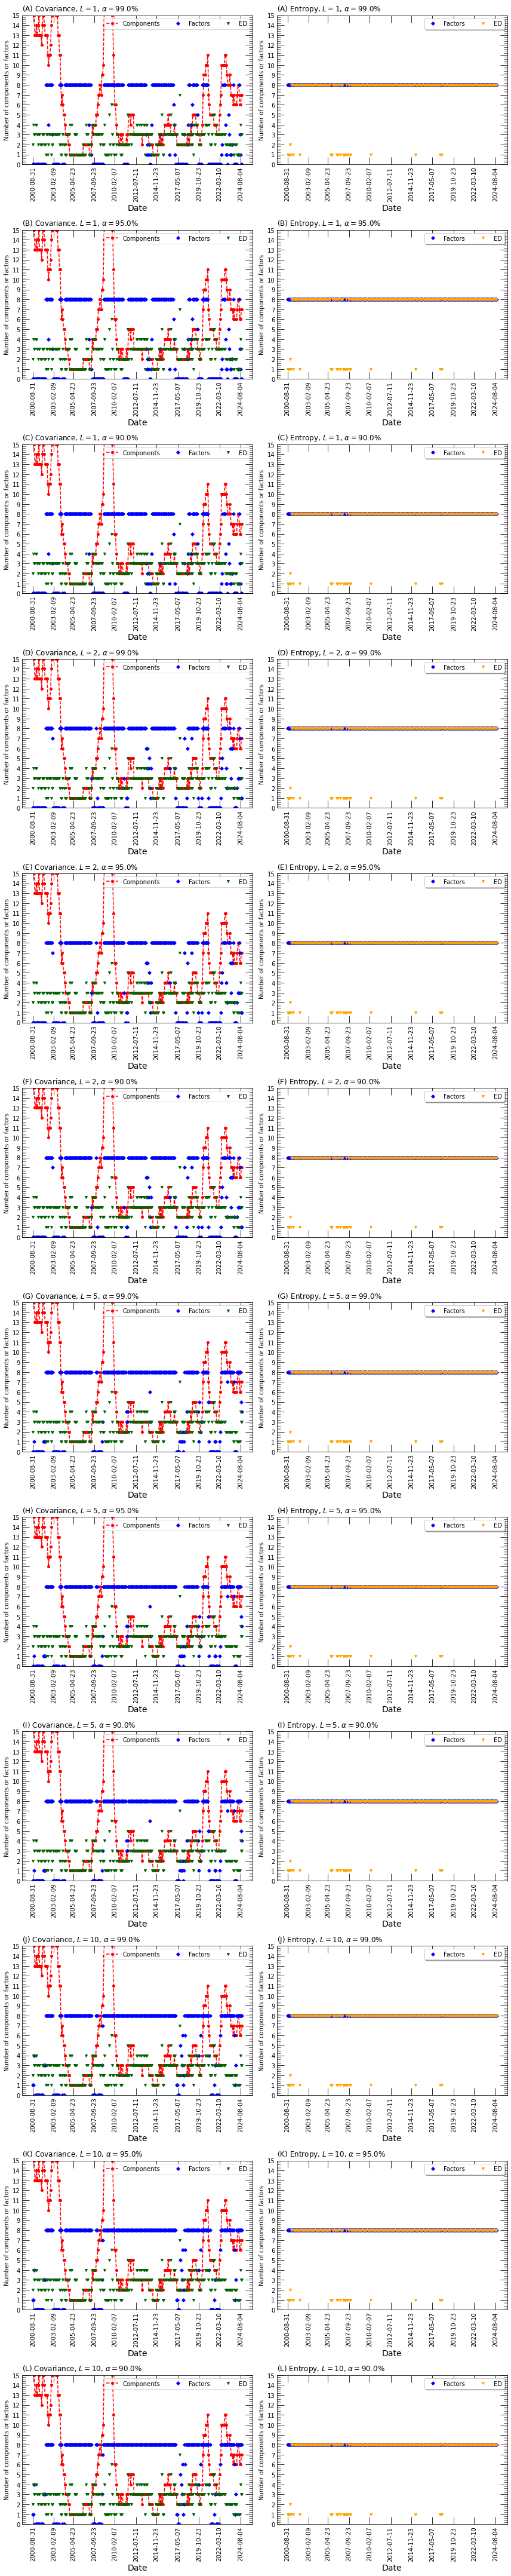

In [8]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_3["level"].unique()
alphas_ = df_final_3["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_3[((df_final_3["level"] == levels_[i]) & (df_final_3["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        #ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "orange", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_)+ 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()

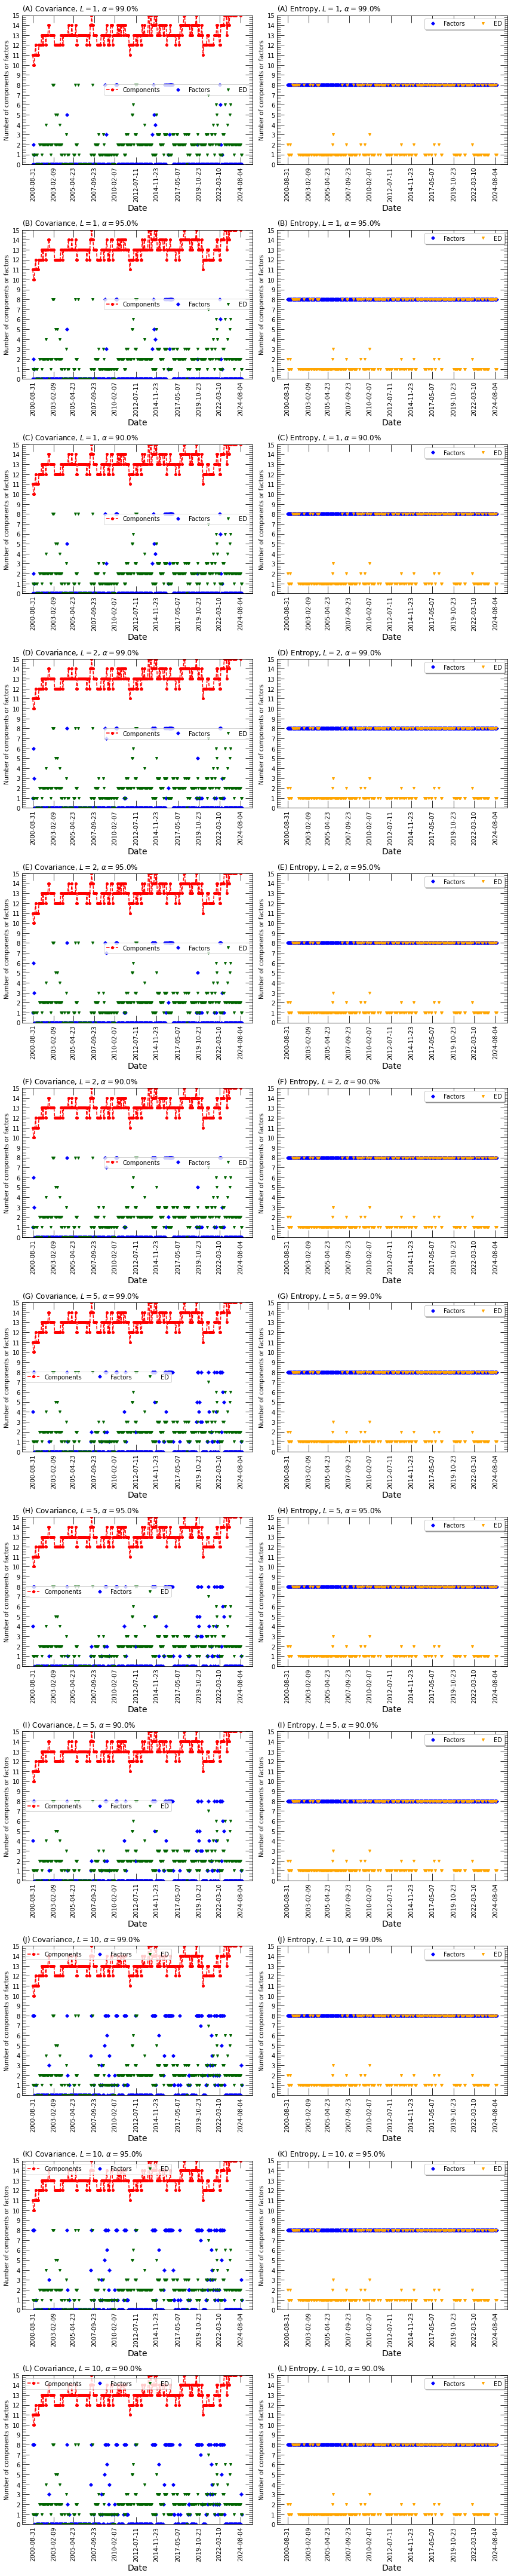

In [9]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as mtick # type: ignore

levels_ = df_final_4["level"].unique()
alphas_ = df_final_4["alpha"].unique()

fig,ax = plt.subplots(len(levels_) * len(alphas_), 2)
fig.set_size_inches(w = 12, h = 60)
ms = 4

for i in range(len(levels_)):
    for j in range(len(alphas_)):
        df_aux = df_final_4[((df_final_4["level"] == levels_[i]) & (df_final_4["alpha"] == alphas_[j]))]

        time_labels = pd.date_range(
            start = df_aux["final_date"].min(),
            end = df_aux["final_date"].max(),
            periods = 20
        ).strftime("%Y-%m-%d")

        # Components
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_components_cov"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        #ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_components_entropy"], color = "red", marker = "o", linestyle = "--", markersize = ms, label = "Components")
        # Factors
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["n_factors_cov"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["n_factors_entropy"], color = "blue", marker = "D", linestyle = "", markersize = ms, label = "Factors")
        # Edge Distribution
        ax[j + i * len(alphas_), 0].plot(df_aux["final_date"], df_aux["edge_distribution_cov"], color = "darkgreen", marker = "v", linestyle = "", markersize = ms, label = "ED")
        ax[j + i * len(alphas_), 1].plot(df_aux["final_date"], df_aux["edge_distribution_entropy"], color = "orange", marker = "v", linestyle = "", markersize = ms, label = "ED")
        # Axis formatter
        ax[j + i * len(alphas_), 0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 0].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 0].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 0].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 0].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 0].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 0].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 0].legend(fancybox = True, shadow = False, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 0].set_title(
            r"({}) Covariance, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

        ax[j + i * len(alphas_), 1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 10, length = 12)
        ax[j + i * len(alphas_), 1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 10, length = 6)
        ax[j + i * len(alphas_), 1].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks = 100))
        ax[j + i * len(alphas_), 1].xaxis.set_minor_locator(mdates.AutoDateLocator(maxticks = 200))
        ax[j + i * len(alphas_), 1].yaxis.set_major_locator(mtick.MaxNLocator(15))
        ax[j + i * len(alphas_), 1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 15))
        ax[j + i * len(alphas_), 1].set_xlabel("Date", fontsize = 14)        
        ax[j + i * len(alphas_), 1].set_ylabel("Number of components or factors", fontsize = 10)
        ax[j + i * len(alphas_), 1].tick_params(axis = "x", labelrotation = 90)
        ax[j + i * len(alphas_), 1].set_ylim(0,15) #bbox_to_anchor=(1.1, 1.05)
        ax[j + i * len(alphas_), 1].legend(fancybox = True, shadow = True, ncol = 3, fontsize = 10)
        ax[j + i * len(alphas_), 1].set_title(
            r"({}) Entropy, $L={}$, $\alpha={}\%$".format(chr(j + i * len(alphas_) + 65), levels_[i], (1 - alphas_[j]) * 100),
            loc = "left",
            y = 1.005,
            fontsize = 12
        )

plt.tight_layout()
plt.show()